In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("output-data/emails_categorized.csv")

print("\nDataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())


Dataset shape: (274, 14)

Columns: ['id', 'subject', 'email_text', 'final_category', 'route', 'proto_score', 'order_id', 'order_ids_all', 'urls', 'emails', 'spam_score', 'spam_signals', 'spam_flag_final', 'low_confidence']



=== CATEGORY DISTRIBUTION ===
final_category
Product Question                   59
Order Status                       57
Return / Complaint                 49
Store / Delivery / Availability    35
Order Cancel                       34
Order Modify                       19
Cooperation / Partnership          11
Spam / Phishing                    10
Name: count, dtype: int64

Percentage (%) distribution:
final_category
Product Question                   21.53
Order Status                       20.80
Return / Complaint                 17.88
Store / Delivery / Availability    12.77
Order Cancel                       12.41
Order Modify                        6.93
Cooperation / Partnership           4.01
Spam / Phishing                     3.65
Name: proportion, dtype: float64


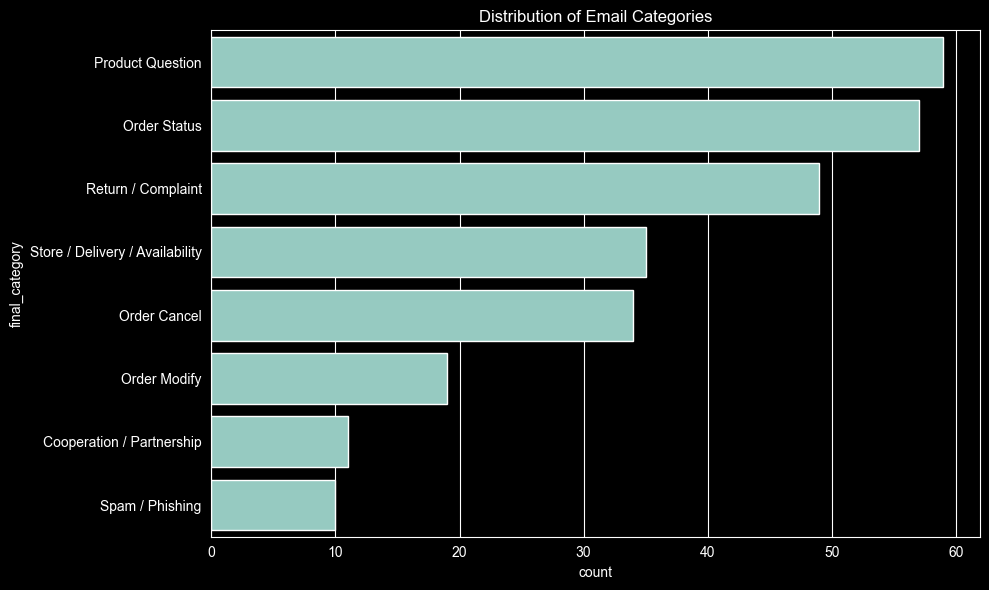

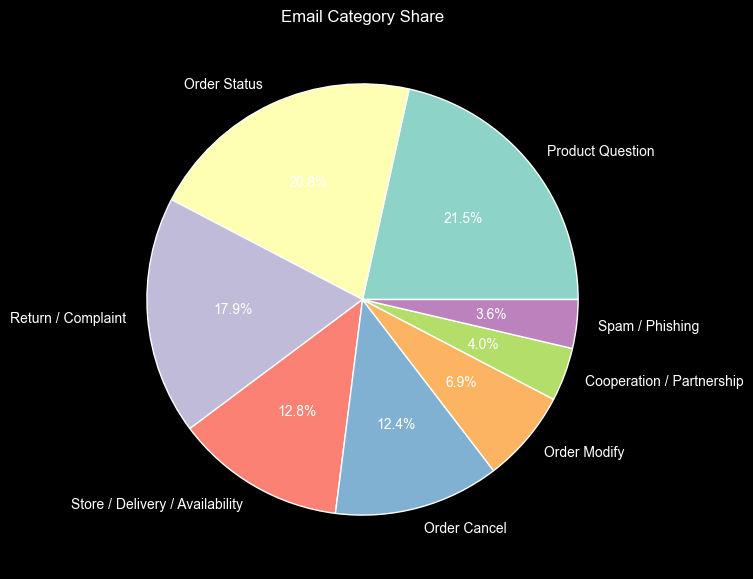

In [42]:
# =========================
# 1. CATEGORY DISTRIBUTION
# =========================

print("\n=== CATEGORY DISTRIBUTION ===")
cat_counts = df["final_category"].value_counts()
print(cat_counts)

cat_percent = df["final_category"].value_counts(normalize=True) * 100
print("\nPercentage (%) distribution:")
print(cat_percent.round(2))


plt.figure(figsize=(10,6))
sns.countplot(data=df, y="final_category",
              order=df["final_category"].value_counts().index)
plt.title("Distribution of Email Categories")
plt.tight_layout()
plt.show()

category_counts = df["final_category"].value_counts()

plt.figure(figsize=(7,7))
plt.pie(
    category_counts,
    labels=category_counts.index,
    autopct="%1.1f%%"
)
plt.title("Email Category Share")
plt.show()

## 1) Identified Categories

Based on dataset analysis (manual inspection + embedding-based prototype classification), the following main categories were identified:

### 1. Order Status
Customers asking about delivery status, delays or tracking information.
This was one of the most frequent and repetitive request types.

### 2. Order Cancel
Requests where the customer wants to completely stop or cancel an existing order before delivery.
These cases may trigger refund processing and require validation of order status, therefore they must be handled carefully due to their financial implications.

### 3. Order Modify
Requests to update or adjust order details while keeping the order active (e.g., address change, adding products, updating recipient information or payment method).
Although the order remains valid, such changes can affect logistics and processing workflows, requiring controlled handling.


### 4. Return / Complaint
Product returns, missing items, wrong products or refund-related issues.
This category is sensitive from a customer satisfaction perspective.

### 5. Product Question
Questions about ingredients, dosage, product differences or recommendations.
These are typically informational and suitable for automation.

### 6. Store / Delivery / Availability
Questions about shipping countries, physical stores or product availability.
Mostly standardized FAQ-type requests.

### 7. Cooperation / Partnership
Business or marketing collaboration inquiries (B2B, influencer, wholesale).
These should be routed to the appropriate business team.

### 8. Spam / Phishing
Suspicious or fraudulent messages detected via rule-based spam filtering.

These categories naturally emerged from the dataset structure and represent the main types of customer interactions in an e-commerce environment.
They cover the full dataset, are semantically distinct, and allow efficient routing between chatbot automation and human agents.



=== SPAM ANALYSIS ===
Spam emails: 10
Spam percentage: 3.65%


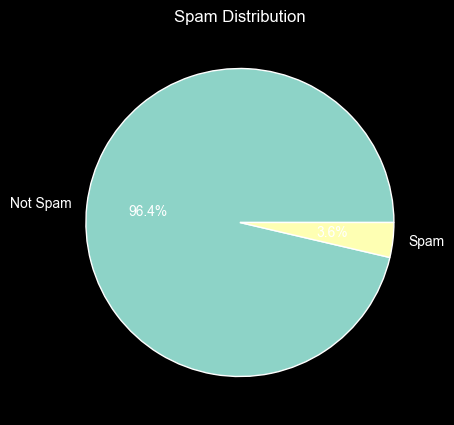

In [10]:
# SPAM ANALYSIS

print("\n=== SPAM ANALYSIS ===")
spam_count = df["spam_flag_final"].sum()
spam_percent = df["spam_flag_final"].mean() * 100

print(f"Spam emails: {spam_count}")
print(f"Spam percentage: {spam_percent:.2f}%")

plt.figure(figsize=(5,5))
df["spam_flag_final"].value_counts().plot.pie(
    autopct="%1.1f%%",
    labels=["Not Spam", "Spam"])
plt.title("Spam Distribution")
plt.ylabel("")
plt.show()

---

# Automatization by Category

In [43]:
import plotly.express as px
import numpy as np

analysis = df.groupby("final_category").agg(
    volume=("id", "count"),
    bot_ratio=("route", lambda x: (x == "bot").mean())
).reset_index()

analysis["dominant"] = np.where(
    analysis["bot_ratio"] >= 0.5,
    "Bot-dominant",
    "Human-dominant"
)

fig = px.scatter(
    analysis,
    x="bot_ratio",
    y="volume",
    size="volume",
    color="dominant",
    text="final_category",
    size_max=40,
    title="Automation Opportunity Matrix"
)

fig.update_traces(textposition="top center")
fig.update_layout()

fig.add_vline(
    x=0.5,
    line_dash="dash",
    line_color="white"
)

fig.update_layout(
    xaxis_title="Automation Share (Bot Handling %) →",
    yaxis_title="Category Volume →"
)

fig.write_image("automation_matrix.png", scale=3)
fig.show()


## Low Hanging Fruits (Priority for Automation)

Based on volume and current automation share, the following categories represent the strongest immediate opportunities for automation:

### 1. Store / Delivery / Availability
These emails include questions about shipping destinations, delivery times, store locations, payment methods, or product availability.
They are highly standardized and FAQ-driven, making them ideal for full automation.

### 2. Product Question
Questions about ingredients, dosage, product differences, or recommendations.
These are informational in nature, repetitive, and low-risk. With structured knowledge sources, they can be handled reliably by a chatbot.

### 3. Order Status
Requests regarding order tracking and delivery progress.
When connected to internal order APIs, these can be automated efficiently with minimal human intervention.


## Why prioritize these categories?

- They have relatively high volume in the dataset.
- They show strong bot-handling dominance in the automation matrix.
- Responses are structured and predictable.
- They carry low operational, financial, and legal risk.
- They require minimal human judgment.

Focusing automation efforts on these categories can significantly reduce support workload while maintaining service quality and response speed.

---

# Confidence vs Category Stability

In [44]:
import plotly.express as px

# агрегуємо
confidence_summary = (
    df.groupby("final_category")
    .agg(
        mean_conf=("proto_score", "mean"),
        std_conf=("proto_score", "std"),
        volume=("id", "count")
    )
    .reset_index()
    .sort_values("mean_conf", ascending=False)
)

fig = px.bar(
    confidence_summary,
    x="final_category",
    y="mean_conf",
    error_y="std_conf",
    text="mean_conf",
    title="Average Model Confidence by Category (with Variability)"
)

fig.update_traces(
    texttemplate="%{text:.3f}",
    textposition="outside"
)

fig.update_layout(
    xaxis_title="Category",
    yaxis_title="Average Confidence",
    showlegend=False
)

fig.write_image("confidence_mean_std.png", scale=3)
fig.show()


## Average Model Confidence by Category

This analysis evaluates how confidently the embedding-based classifier assigns emails to each category.

For each category, the following metrics were calculated:

- **Mean confidence** – average cosine similarity score between email embeddings and category prototypes
- **Standard deviation** – variability of confidence within the category
- **Volume** – number of emails in the category

The chart shows:

- Bars = average model confidence per category
- Error bars = standard deviation (prediction variability)

### Observations

- All categories show relatively high average confidence (~0.83–0.87), indicating stable semantic separation.
- **Store / Delivery / Availability** and **Cooperation / Partnership** show the highest confidence levels, suggesting clear and consistent patterns.
- **Spam / Phishing** has slightly lower average confidence, likely due to more diverse wording patterns.
- Variability (error bars) remains relatively small across categories, which indicates consistent classification performance.

### Conclusion

The model demonstrates strong semantic consistency across categories.
High average confidence combined with low variability supports the reliability of the prototype-based embedding approach.

This analysis validates that the identified categories are well-separated in embedding space and suitable for downstream routing decisions.


---

# Chaos Index

In [45]:
chaos = (
    df.groupby("final_category")
    .agg(
        mean_conf=("proto_score", "mean"),
        std_conf=("proto_score", "std"),
        volume=("id", "count")
    )
    .reset_index()
)

chaos["chaos_index"] = chaos["std_conf"] * chaos["volume"]

chaos = chaos.sort_values("chaos_index", ascending=False)

import plotly.express as px

fig = px.bar(
    chaos,
    x="final_category",
    y="chaos_index",
    text="chaos_index",
    title="Chaos Index by Category"
)

fig.update_traces(texttemplate="%{text:.3f}", textposition="outside")
fig.write_image("chaos_index.png", scale=3)
fig.show()


## Chaos Index Analysis

To better understand which categories are more complex or inconsistent for the model, I introduced a custom metric called **Chaos Index**.

### Definition

For each category, the following metrics were calculated:

- **Mean confidence** (`mean_conf`) – average prototype similarity score
- **Standard deviation of confidence** (`std_conf`) – variability of prediction confidence
- **Volume** – number of emails in the category

The **Chaos Index** is defined as:

Chaos Index = std_conf × volume

### Interpretation

- A **high Chaos Index** means:
  - High variation in model confidence
  - Large number of emails
  - Potential semantic diversity or inconsistency
  - Category may require refinement or human oversight

- A **low Chaos Index** means:
  - Stable predictions
  - Low semantic ambiguity
  - Good candidate for automation

### Observations

- **Return / Complaint** shows the highest Chaos Index, indicating that this category is both high-volume and semantically diverse. It likely contains edge cases and sensitive issues (refunds, damaged goods), making it less suitable for full automation.

- **Product Question** also has relatively high variability, suggesting a wide range of product-related inquiries.

- **Order Status** and **Store / Delivery / Availability** demonstrate lower chaos, meaning the model handles them more consistently.

- **Spam / Phishing** and **Cooperation / Partnership** show very low chaos, indicating clear semantic separation and stable classification.

### Conclusion

The Chaos Index helps identify which categories are:

- Good candidates for automation (low chaos, high confidence stability)
- Risky or complex categories that should remain partially or fully human-handled

This metric provides an additional decision layer beyond simple volume or confidence analysis and supports a data-driven routing strategy.


---

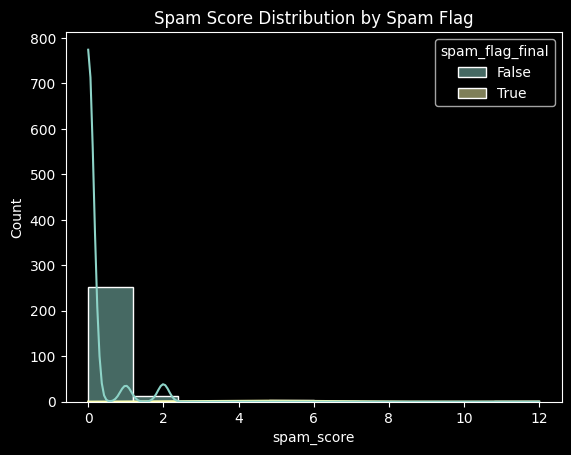

In [80]:
sns.histplot(data=df, x="spam_score", hue="spam_flag_final", bins=10, kde=True)
plt.title("Spam Score Distribution by Spam Flag")
plt.show()


Top categories by volume:
final_category
Return / Complaint                 79
Product Question                   55
Order Cancel / Modify              55
Order Status                       39
Store / Delivery / Availability    25
Cooperation / Partnership          11
Spam / Phishing                    10
Name: count, dtype: int64


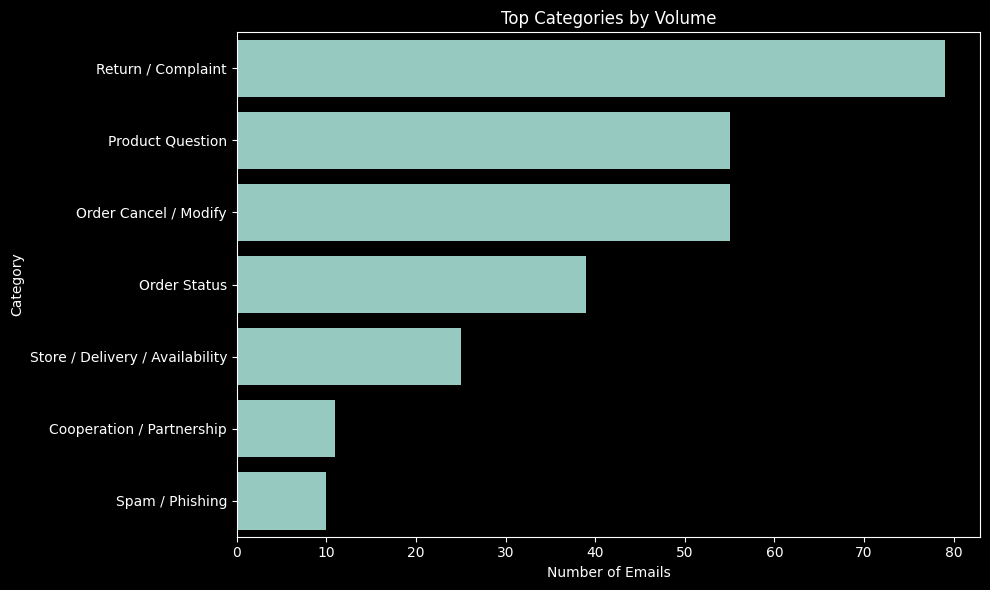

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count categories
category_counts = df["final_category"].value_counts()

print("Top categories by volume:")
print(category_counts)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(
    x=category_counts.values,
    y=category_counts.index
)

plt.title("Top Categories by Volume")
plt.xlabel("Number of Emails")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

## Low Hanging Fruits (Priority for Automation)

The most suitable email types for immediate automation (low hanging fruits) are:

### 1. Product Questions
Questions about ingredients, dosage, differences between products, or general recommendations.
These are repetitive, informational, and low-risk.

### 2. Store / Delivery / Availability
Shipping destinations, store locations, delivery options, or opening hours.
These are standardized FAQ-type requests with clear answers.

### 3. Order Status
Requests about delivery status or tracking information.
These can be automated if connected to order tracking systems.

---

### Why prioritize these?

- High frequency in the dataset
- Clear and structured answers
- Low financial and legal risk
- Minimal need for human judgment

Automating these categories can significantly reduce support workload while maintaining service quality.

